# Multivariate Forecasting Long Sequence Time Series with NHITS

This notebook outlines the application of [NHITS](https://arxiv.org/abs/2201.12886), a recently-proposed model for time series forecasting, to a collection of hourly data
from California Department of Transportation, which describes the road occupancy rates measured
by 862 different sensors on San Francisco Bay area freeways.

This demo uses an implementation of NHITS from the neuralforecast package. [neuralforecast](https://github.com/jdb78/pytorch-forecasting) is a package/repository that provides implementations of several state-of-the-art deep learning-based forecasting models, namely [Autoformer](https://arxiv.org/abs/2106.13008), [Informer](https://arxiv.org/abs/2012.07436), [NHITS](https://arxiv.org/abs/2201.12886) and [ES-RNN](https://www.sciencedirect.com/science/article/abs/pii/S0169207019301153). Similar to PyTorch Forecasting, neuralforecast is built using [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/), making it easier to train in multi-GPU compute environments, out-of-the-box.

**Note:** neuralforecast is a relatively new package that has been gaining traction because, unlike more mature packages, it supports recent state-of-the-art methods like NHITS and Autoformer. That being said, the documentation is sparse and the package is not as mature as others we have used in other demos ([PyTorch Forecasting](https://pytorch-forecasting.readthedocs.io/en/stable/), [Prophet](https://facebook.github.io/prophet/)). In any event, neuralforecast provides a great oppurtunity to explore bleeding edge time series forecasting methods.

## Environment Configuration and Package Imports



```{note}
Note for Colab Users: Run the following cell to install neuralforecast and pytorch_lightning.
After installation completes, you will likely need to restart the Colab runtime.
If this is the case, a button RESTART RUNTIME will appear at the bottom of the next cell's output.
```

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch_lightning
    !pip install neuralforecast==0.0.6

  warnings.filterwarnings("ignore") # Comment out

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
import pytorch_lightning as pl

import neuralforecast as nf
from neuralforecast.data.datasets.epf import EPF
from pytorch_lightning.callbacks import EarlyStopping
from neuralforecast.data.tsloader import TimeSeriesLoader
from neuralforecast.experiments.utils import create_datasets

## Hyperparameter Defintions

In [ ]:
# General Hyperparameters
VAL_PERC = .1
TEST_PERC = .1

In [ ]:
# Model Configuration Hyperparameters
mc = {}
mc['model'] = 'n-hits' # Model Name
mc['mode'] = 'simple'
mc['activation'] = 'SELU' # Activation function


mc['n_time_in'] = 96 # Length of input sequences
mc['n_time_out'] = 96 # Length of Output Sequences
mc['n_x_hidden'] = 8 # Number of hidden output channels of exogenous_tcn and exogenous_wavenet stacks.
mc['n_s_hidden'] = 0 # Number of encoded static features

mc['stack_types'] = ['identity', 'identity', 'identity'] # List of stack types. Subset from ['seasonality', 'trend', 'identity', 'exogenous', 'exogenous_tcSubset from ['seasonality', 'trend', 'identity', 'exogenous', 'exogenous_tcn', 'exogenous_wavenet'].
mc['constant_n_blocks'] = 1 # Constant n_blocks across stacks
mc['constant_n_layers'] = 2 # Constant n_layers across stacks
mc['constant_n_mlp_units'] = 256 # Constant n_mlp_units across stacks
mc['n_pool_kernel_size'] = [4, 2, 1]  # Pooling size for input for each stack. Note that len(n_pool_kernel_size) = len(stack_types).
mc['n_freq_downsample'] = [24, 12, 1] # Downsample multiplier of output for each stack. Note that len(n_freq_downsample) = len(stack_types).
mc['pooling_mode'] = 'max' # Pooling type. An item from ['average', 'max']
mc['interpolation_mode'] = 'linear' # Interpolation function. An item from ['linear', 'nearest', 'cubic']
mc['shared_weights'] = False # If True, all blocks within each stack will share parameters.

# Optimization and regularization parameters
mc['initialization'] = 'lecun_normal'  #Initialization function. An item from ['orthogonal', 'he_uniform', 'glorot_uniform', 'glorot_normal', 'lecun_normal'].
mc['learning_rate'] = 0.001 # Learning rate between (0, 1).
mc['batch_size'] = 1 # Batch size
mc['n_windows'] = 32
mc['lr_decay'] = 0.5 # Decreasing multiplier for the learning rate.
mc['lr_decay_step_size'] = 2 # Steps between each learning rate decay.
mc['max_epochs'] = 1 # Maximum number of training epochs
mc['max_steps'] = None # Maximum number of validation epochs
mc['early_stop_patience'] = 20 #Number of consecutive violations of early stopping criteria to end training
mc['eval_freq'] = 500 # How many steps between evaluations
mc['batch_normalization'] = False # Whether perform batch normalization.
mc['dropout_prob_theta'] = 0.0 # Float between (0, 1). Dropout for Nbeats basis.
mc['dropout_prob_exogenous'] = 0.0 #
mc['weight_decay'] = 0 # L2 penalty for optimizer.
mc['loss_train'] = 'MAE' # Loss to optimize. An item from ['MAPE', 'MASE', 'SMAPE', 'MSE', 'MAE', 'QUANTILE', 'QUANTILE2'].
mc['loss_hypar'] = 0.5 # Hyperparameter for chosen loss.
mc['loss_valid'] = mc['loss_train'] #  Validation loss.  An item from ['MAPE', 'MASE', 'SMAPE', 'RMSE', 'MAE', 'QUANTILE'].
mc['random_seed'] = 1 # random_seed for pseudo random pytorch initializer and numpy random generator.

# Data Parameters
mc['idx_to_sample_freq'] = 1
mc['val_idx_to_sample_freq'] = 1
mc['n_val_weeks'] = 52
mc['normalizer_y'] = None
mc['normalizer_x'] = 'median'
mc['complete_windows'] = False # Consider only full sequences in forecasting horizon
mc['frequency'] = 'h' # Frequency of the data


# Structure of hidden layers for each stack type.
# Each internal list should contain the number of units of each hidden layer.
# Note that len(n_hidden) = len(stack_types).
mc['n_mlp_units'] = len(mc['stack_types']) * [ mc['constant_n_layers'] * [int(mc['constant_n_mlp_units'])] ]
mc['n_blocks'] =  len(mc['stack_types']) * [ mc['constant_n_blocks'] ] # Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).
mc['n_layers'] =  len(mc['stack_types']) * [ mc['constant_n_layers'] ] # Number of layers for each stack type. Note that len(n_layers) = len(stack_types).

print(65*'=')
print(pd.Series(mc))
print(65*'=')


model                                                   n-hits
mode                                                    simple
activation                                                SELU
n_time_in                                                   96
n_time_out                                                  96
n_x_hidden                                                   8
n_s_hidden                                                   0
stack_types                     [identity, identity, identity]
constant_n_blocks                                            1
constant_n_layers                                            2
constant_n_mlp_units                                       256
n_pool_kernel_size                                   [4, 2, 1]
n_freq_downsample                                  [24, 12, 1]
pooling_mode                                               max
interpolation_mode                                      linear
shared_weights                                         

## Load Data
We start by loading the data. neuralforecast provides utilities for loading a [variety of different datasets](https://nixtla.github.io/neuralforecast/data_datasets__long_horizon.html) popular in the time series forecasting domain. Conveniently, the loaded data is in the format that is expected by the model that we define in the subsequent section. In particular, we call the `load` function with an argument specifying the dataset to load three dataframes:
- `Y_df`: (pd.DataFrame) Target time series with columns ['unique_id', 'ds', 'y']
- `X_df`: (pd.DataFrame) Exogenous time series with columns ['unique_id', 'ds', 'y']
- `S_df` (pd.DataFrame) Static exogenous variables with columns ['unique_id'] and static variables.

The columns referenced above are defined as follows:
- `unique_id`: column used to identify which time series the dataframe row corresponds to. The number of unique values in the column is the number of time series in the dataset.
- `ds`: column used to identify the time stamp the dataframe row corresponds to.

In this way, a combination of `unique_id` and `ds` identify a sample in  `Y_df` and `X_df`. Thus, the total number of rows they contain is the product of the unique observations in `unique_id` and `ds`. On the other hand, `S_df` contains a row for each exogneous variable-time series pairing. If no exogenous varables exist for any of the time sereis, `S_df` is `None`.

For datasets that are not supported out of the box for the package, we must construct these dataframes ourselves with the format specified above.

In [ ]:
Y_df, X_df, S_df = nf.data.datasets.long_horizon.LongHorizon.load('data', 'TrafficL')

In [ ]:
Y_df

,unique_id,ds,y
0,0,2016-07-01 02:00:00,-0.711224
1,0,2016-07-01 03:00:00,-0.672014
2,0,2016-07-01 04:00:00,-0.724294
3,0,2016-07-01 05:00:00,-0.725928
4,0,2016-07-01 06:00:00,-0.721027
...,...,...,...
15122923,OT,2018-07-01 21:00:00,0.765917
15122924,OT,2018-07-01 22:00:00,0.389237
15122925,OT,2018-07-01 23:00:00,0.172360
15122926,OT,2018-07-02 00:00:00,-0.090175


In [ ]:
X_df

,unique_id,ds,ex_1,ex_2,ex_3,ex_4
0,0,2016-07-01 02:00:00,-0.413043,0.166667,-0.500000,-0.00137
1,0,2016-07-01 03:00:00,-0.369565,0.166667,-0.500000,-0.00137
2,0,2016-07-01 04:00:00,-0.326087,0.166667,-0.500000,-0.00137
3,0,2016-07-01 05:00:00,-0.282609,0.166667,-0.500000,-0.00137
4,0,2016-07-01 06:00:00,-0.239130,0.166667,-0.500000,-0.00137
...,...,...,...,...,...,...
15122923,OT,2018-07-01 21:00:00,0.413043,0.500000,-0.500000,-0.00411
15122924,OT,2018-07-01 22:00:00,0.456522,0.500000,-0.500000,-0.00411
15122925,OT,2018-07-01 23:00:00,0.500000,0.500000,-0.500000,-0.00411
15122926,OT,2018-07-02 00:00:00,-0.500000,-0.500000,-0.466667,-0.00137


In [ ]:
S_df

```{important}
This notebook should run in a high-RAM env. If your runtime crashes due to RAM limits, adjust "portion_to_use" accordingling.
```

In [ ]:
if 'google.colab' in str(get_ipython()):
    portion_to_use = 0.5
    X_df = X_df[0:int(len(X_df) * 0.5)]
    Y_df = Y_df[0:int(len(Y_df) * 0.5)]

In [ ]:
Y_df['ds'] = pd.to_datetime(Y_df['ds']) # Convert ds column to datetime format
X_df['ds'] = pd.to_datetime(X_df['ds']) # Convert ds column to datetime format
f_cols = X_df.drop(columns=['unique_id', 'ds']).columns.to_list()

## Data Splitting

The data is split sequentially into train, validation and test based on `VAL_PERC` and `TEST_PERC` global variables. We will withhold the last `TEST_PERC` of data for testing. In the code below, we are very careful to ensure that when training and validating the model, it does not have access to the withheld data.

The neuralforecast package's function [create_datasets](https://nixtla.github.io/neuralforecast/experiments__utils.html#create_datasets) allows us to generate a [TSDataset](https://nixtla.github.io/neuralforecast/data__tsdataset.html) for the train, validation and test sets by passing `Y_df`, `X_df` and `S_df` that we defined above. Additionally, we specify the amount of time steps we want in the validation and test datasets, `ds_in_val` and `ds_in_test`.



In [ ]:
n_ds = Y_df["ds"].nunique()
n_val = int(VAL_PERC * n_ds)
n_test = int(TEST_PERC * n_ds)

train_dataset, val_dataset, test_dataset, scaler_y = create_datasets(mc=mc,
                                                                     S_df=None,
                                                                     Y_df=Y_df, X_df=X_df,
                                                                     f_cols=f_cols,
                                                                     ds_in_val=n_val,
                                                                     ds_in_test=n_test)

## Defining Dataloader
The neural forecasting package defines its own dataloader [TimeSeriesLoader](https://nixtla.github.io/neuralforecast/data__tsloader.html). Similar to a regular PyTorch dataloader, we pass a dataset, batch size and other paraneters that inform how each batch of data is loaded.

In [ ]:
train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=int(mc['batch_size']),
                                n_windows=mc['n_windows'],
                                shuffle=True)

val_loader = TimeSeriesLoader(dataset=val_dataset,
                              batch_size=int(mc['batch_size']),
                              shuffle=False)

test_loader = TimeSeriesLoader(dataset=test_dataset,
                               batch_size=int(mc['batch_size']),
                               shuffle=False)

## Model

### NHITS Overview

<p align="center">
<img width="750" alt="NHITS Architecture" src="https://user-images.githubusercontent.com/34798787/156445832-58e5e082-5003-4859-92f6-cb029ddbd378.png">
</p>

NHITS is a popular deep learning based approach to time series forecasting. In particualr, NHITS adapts the NBEATS architecture to perform long sequence time series forecasting (LSTF); a task where the length of the input and output sequence are large. NHITS learns a global model from historical data of one or more time series. Thus, although the input and output space is univariate, NHITS can be used to jointly model a set of related time series. The architecture consists of deep stacks of fully connected layers connected with forward and backward residual links. The forwad links aggregate partial forecast to yield final forecast. Alternatively, backward links subtract out input signal corresponding to already predicted partial forecast from input prior to being passed to the next stack. NHITS builds on NBEATS by enhancing its input decomposition via multi-rate data sampling and its output synthesizer via multi-scale interpolation. This increases both the accuracy and  computational efficiency of the approach in the LSTF setting.

Some additional features of NHITS include:

- **Interpretability**: Allows for hierarchical decomposition of a forecasts into trend and seasonal components which enhances interpretability.
- **Ensembling**: Ensembles models fit with different loss functions and time horizons. The final prediction is mean of models in ensemble.
- **Efficient**: Avoids the use of recurrent structute and predicts entire ouput sequence in single forward pass.

## Model Definition
Using the neuralforecast package, an NHITS model can be initialized using the `NHITS` class. This returns a Pytorch Lighnting model that we will subsequently train and evaluate. There is a large amount of parameters involved in the definition, most of which can stay consistent accross datasets. Some of the arguments that may vary include:
- `n_time_in`: (int) The length of sequences input to the model.
- `n_time_out`: (int) The length of the sequences output by the model.  
- `n_x`: (int) The number of exogenous time series. This equals the number of features included in `X_df`.
- `n_s`: (int) The number of static exogenous variables. This equals the number of features included in `S_df`.
- `frequency `: (string) The frequency of the observations. (hourly:`h`, daily:`d`)

For additional details in regards to the `NHITS` class, consult the  [neuralforecast documentation](https://nixtla.github.io/neuralforecast/models_nhits__nhits.html). Values of model hyperparameters with corresponding defintions is available above in the **Hyperparameter Defintions** section.

In [ ]:
mc['n_x'], mc['n_s'] = train_dataset.get_n_variables()

model = nf.models.nhits.nhits.NHITS(n_time_in=int(mc['n_time_in']),
              n_time_out=int(mc['n_time_out']),
              n_x=mc['n_x'],
              n_s=mc['n_s'],
              n_s_hidden=int(mc['n_s_hidden']),
              n_x_hidden=int(mc['n_x_hidden']),
              shared_weights=mc['shared_weights'],
              initialization=mc['initialization'],
              activation=mc['activation'],
              stack_types=mc['stack_types'],
              n_blocks=mc['n_blocks'],
              n_layers=mc['n_layers'],
              n_mlp_units=mc['n_mlp_units'],
              n_pool_kernel_size=mc['n_pool_kernel_size'],
              n_freq_downsample=mc['n_freq_downsample'],
              pooling_mode=mc['pooling_mode'],
              interpolation_mode=mc['interpolation_mode'],
              batch_normalization = mc['batch_normalization'],
              dropout_prob_theta=mc['dropout_prob_theta'],
              learning_rate=float(mc['learning_rate']),
              lr_decay=float(mc['lr_decay']),
              lr_decay_step_size=float(mc['lr_decay_step_size']),
              weight_decay=mc['weight_decay'],
              loss_train=mc['loss_train'],
              loss_hypar=float(mc['loss_hypar']),
              loss_valid=mc['loss_valid'],
              frequency=mc['frequency'],
              random_seed=int(mc['random_seed']))

## Training and Validation
We first define a pytorch lighting trainer which encapsulates the training process and allows us to easily implement a training and validation loop with the specified parameters. The arguments to the trainer include:
- `max_epochs`: (Optional[int]) – Stop training once this number of epochs is reached.
- `callbacks`: (Union[List[Callback], Callback, None]) – Add a callback or list of callbacks.

Subsequently, we can use the `fit` method of the trainer with the `net`, `train_dataloader` and `val_dataloader` to perform the training and validation loop.

For more information regarding the `pl.Trainer` class, consult the [PyTorch Lightning documentation](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.html#pytorch_lightning.trainer.trainer.Trainer.validate).

In [ ]:
# Set random seed
pl.seed_everything(42)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor="val_loss",
                               min_delta=1e-4,
                               patience=mc['early_stop_patience'],
                               verbose=False,
                               mode="min")

# Init pytorch lightning trainer
trainer = pl.Trainer(accelerator="gpu",
                     devices=1,
                     max_epochs=mc['max_epochs'],
                     gradient_clip_val=1.0,
                     log_every_n_steps=500,
                     check_val_every_n_epoch=1,
                     callbacks=[early_stopping])

# Train and Validate Model
trainer.fit(model, train_loader, val_loader)

## Test

### Inference
We can obtain the predictions of the trained model on the test samples using the predict method of the trainer object. This will output a list the same length as the number of time series. Each entry in this list (ie `outputs[0]`) is a list itself where the first item (ie `outputs[0][0]`) is the ground truth and the second item (ie `outputs[0][1]`) is the prediction.

In [ ]:
# Obtain Predictions on Test Set
model.return_decomposition = False
outputs = trainer.predict(model, test_loader)

### Visualize Predictions
With the trained model from the previous step, we can apply it to the test set to get an unbias estimate of the models performance. Additionally, we can visualize the results to build some intuition about the forecasts being generated.

In [ ]:
input_list, gt_list = [], []
for d in test_loader:
    Y = d["Y"]
    inp = Y[:, :mc['n_time_in']]
    input_list.append(inp)

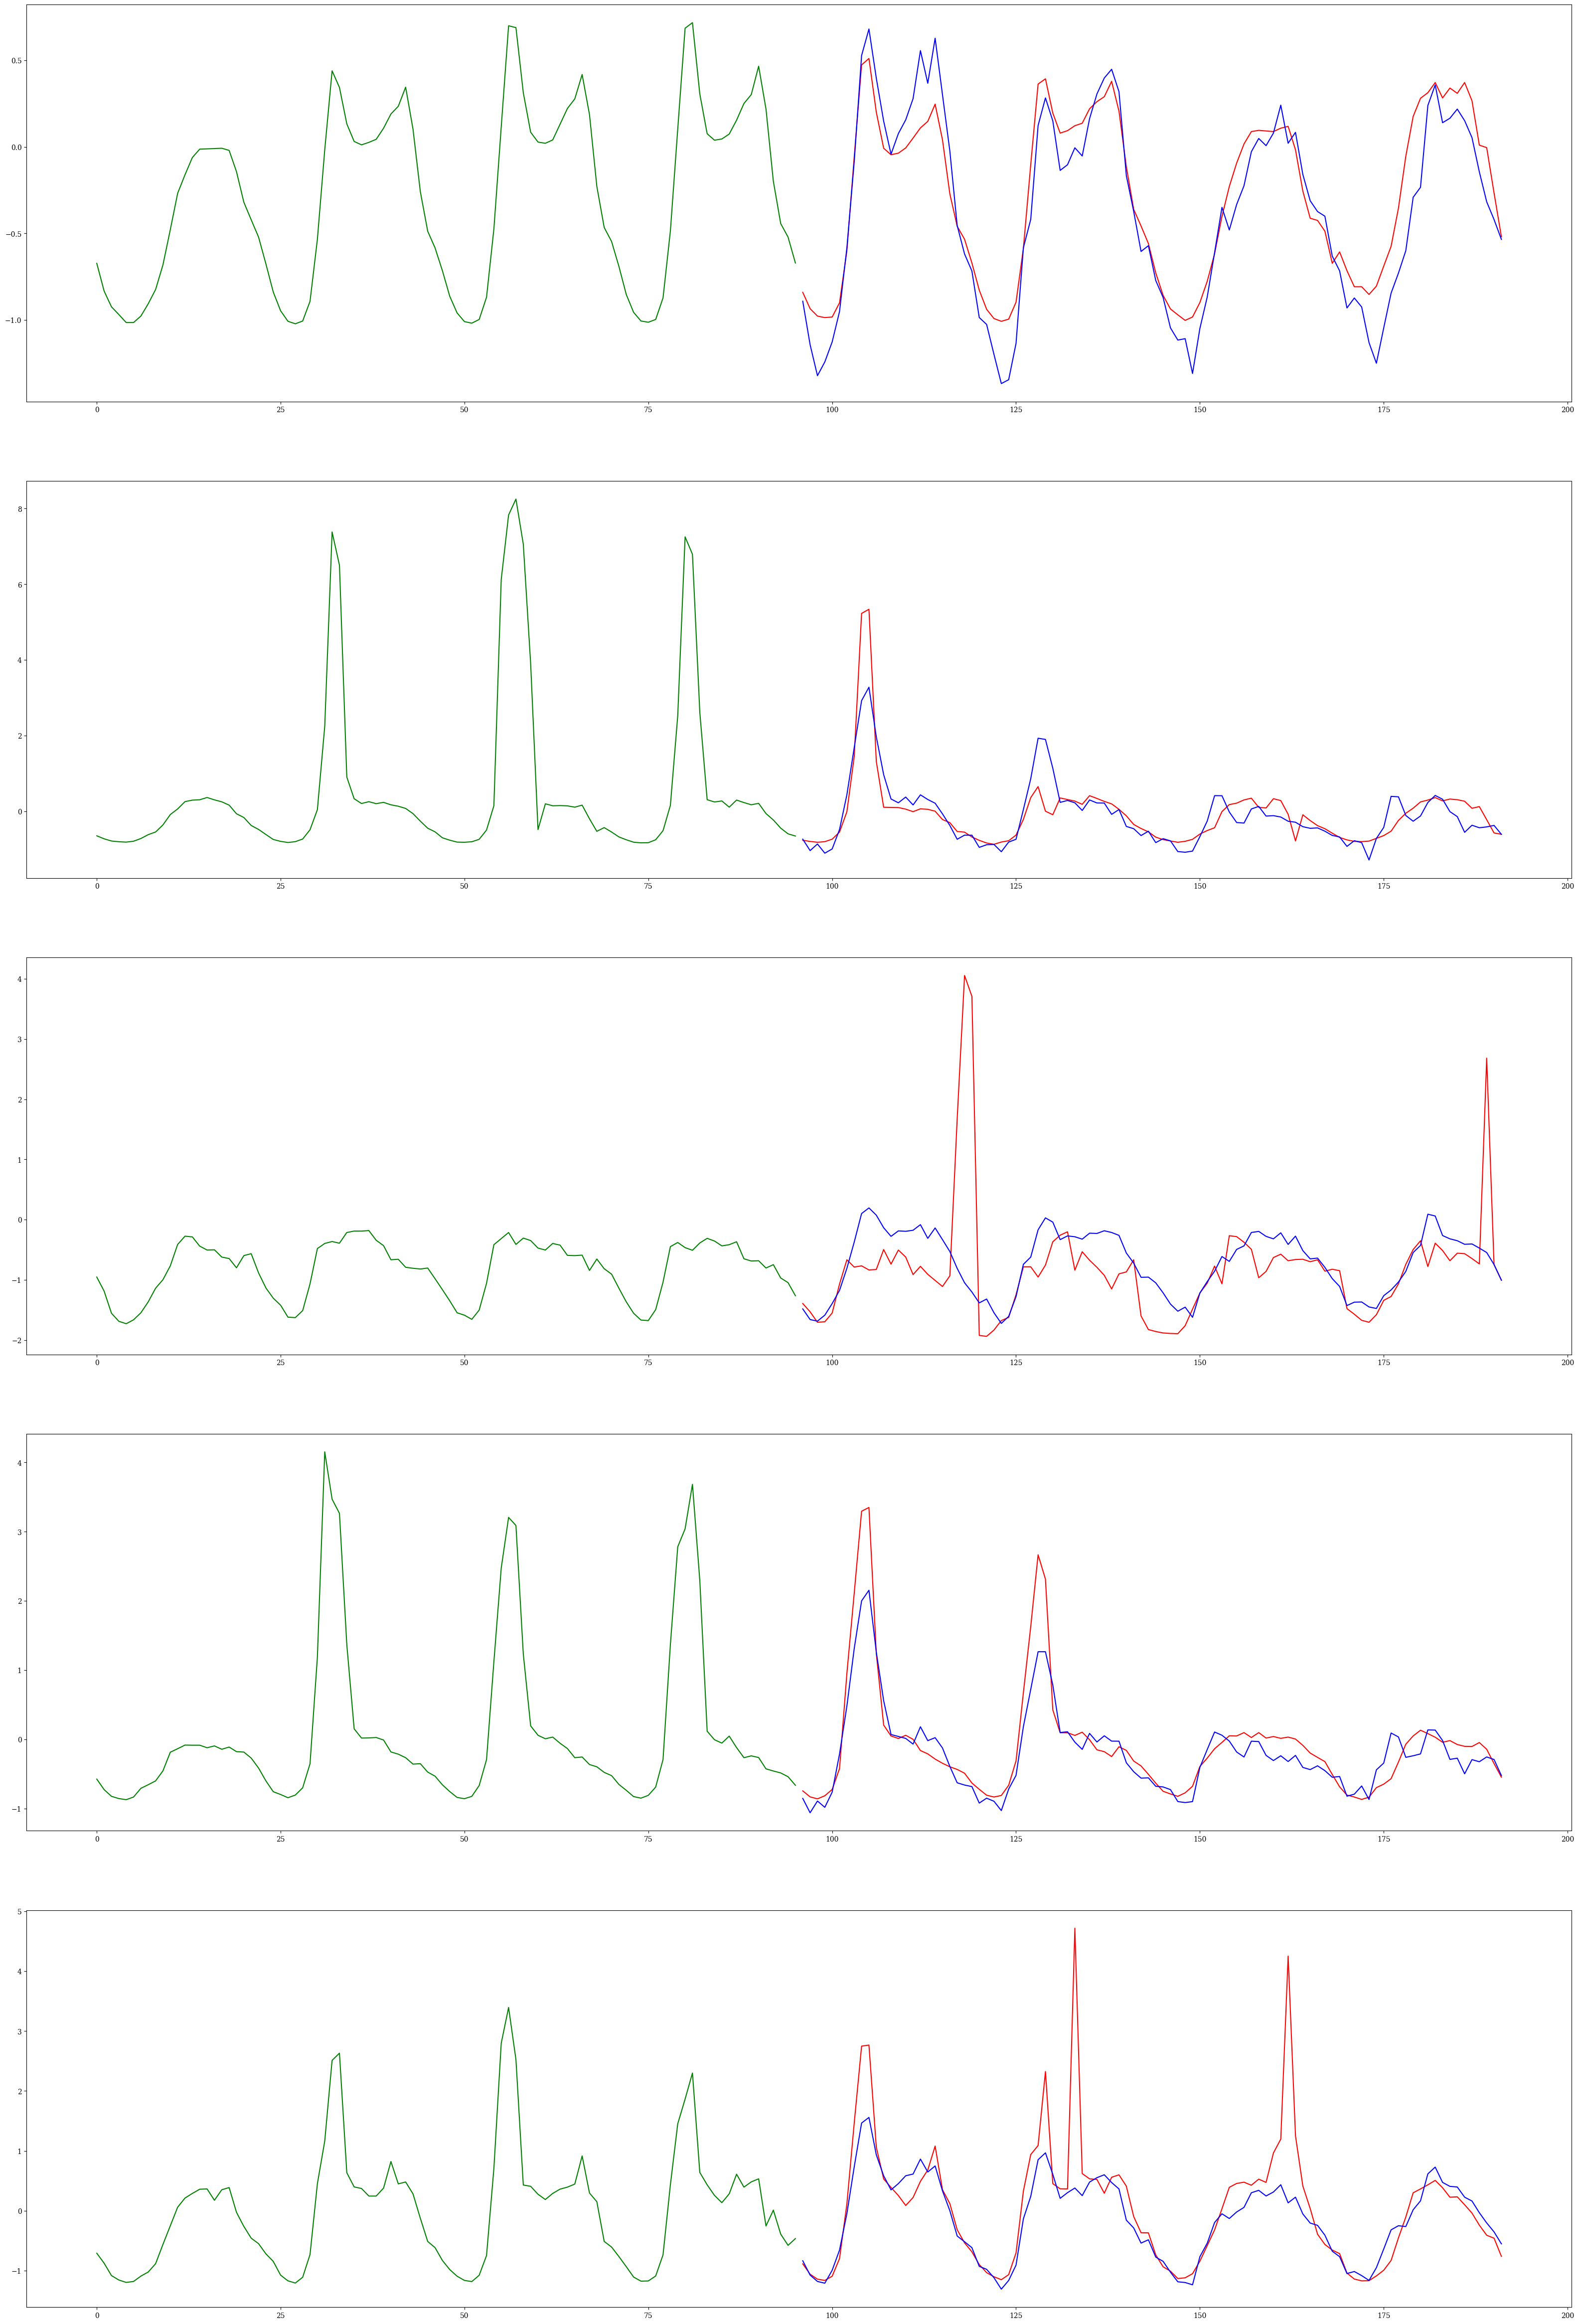

In [ ]:
n_samples = 5
ss_indices = np.random.choice((len(outputs)), n_samples, replace=False).tolist()

f, axarr = plt.subplots(n_samples, 1, figsize=(40, 60))

for i, ss_ind in enumerate(ss_indices):
    inp = input_list[ss_ind][0, :].cpu().numpy()

    out1 = outputs[ss_ind][0][0, :].cpu().numpy()
    out2 = outputs[ss_ind][1][0, :].cpu().numpy()

    inp_index = [j for j in range(mc['n_time_in'])]
    out_index = [j for j in range(mc['n_time_in'], mc['n_time_out'] + mc['n_time_out'])]

    axarr[i].plot(inp_index, inp, c="green")
    axarr[i].plot(out_index, out1, c="red")
    axarr[i].plot(out_index, out2, c="blue")

### Quantitative Resutls
To assess the performance of NHITS on the dataset, we calculate its performance on the test set using a set of metrics that are commonly used in time series forecasting. The metrics include Mean Absolute Error (MAE) and Mean Squared Error (MSE).

In [ ]:
# Aggregate list of ground truth and prediction series in to lists
true_list = [output[0] for output in outputs]
pred_list = [output[1] for output in outputs]

# Stack lists into tensors along the sample/batch dimension
trues = torch.concat(true_list, dim=0)
preds = torch.concat(pred_list, dim=0)

# Calculate Losses
mse = mean_squared_error(trues.cpu().numpy(), preds.cpu().numpy())
mae = mean_absolute_error(trues.cpu().numpy(), preds.cpu().numpy())

print(f"MSE: {mse} MAE: {mae}")

MSE: 0.6308218836784363 MAE: 0.5023184418678284
